In [1]:
#!pip3 install xgboost imblearn sklearn pickle pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser
import os
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from data_preprocessing_v2 import Data_Preprocessing
from model_v2 import model_fit, model_blending
import datetime

In [3]:
def validate_dirs(dir):
    try: 
        if not os.path.exists(dir):
            os.makedirs(dir)  
    except OSError:
        print('Error: Creating directory to store person')

In [4]:
validate_dirs("models")
validate_dirs("result")

In [5]:
train_df = pd.read_csv('train/train.csv')
test_df= pd.read_csv('test/test.csv')


In [6]:
train_df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [7]:
data_processor  = Data_Preprocessing()
train_drop_colums = ['Response','id']
test_drop_colums = ['id']
label_column = 'Response'
key = 'id'
custom_encode_col = "Vehicle_Age"
X, Y = data_processor.data_processing_pipeline(train_df, train_drop_colums , label_column, key, data_type = 'Train', custom_encode_col=custom_encode_col) 


X_test = data_processor.data_processing_pipeline(test_df, test_drop_colums , label_column, key, data_type = 'Test', custom_encode_col=custom_encode_col) 

Categorical_Columns ::  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
Numerical_Columns ::  Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')
** Train **
CATEGORICAL COLUMN ENCODED ::  Gender
CATEGORICAL COLUMN ENCODED ::  Vehicle_Age
CATEGORICAL COLUMN ENCODED ::  Vehicle_Damage
381109


/home/omen/Desktop/anayltic hackathon/data_preprocessing_v2.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_df[key]= df[key]


Categorical_Columns ::  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
Numerical_Columns ::  Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')
** Test **
CATEGORICAL COLUMN ENCODED ::  Gender
CATEGORICAL COLUMN ENCODED ::  Vehicle_Age
CATEGORICAL COLUMN ENCODED ::  Vehicle_Damage
127037


In [8]:
X.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender,Vehicle_Age,Vehicle_Damage
0,44,1,28.0,0,40454.0,26.0,217,1,2,1
1,76,1,3.0,0,33536.0,26.0,183,1,0,0
2,47,1,28.0,0,38294.0,26.0,27,1,2,1
3,21,1,11.0,1,28619.0,152.0,203,1,1,0
4,29,1,41.0,1,27496.0,152.0,39,0,1,0


# XGBoost and CatBoost
* `KFold`
* `StratifiedShuffleSplit`


In [9]:
def save_result(result, file_name):
    df_sub = pd.read_csv('sample_submission.csv')
    df_sub.head()
    df_xgb = df_sub.copy()
    df_xgb['Response'] = result
    df_xgb.head()
    df_xgb.to_csv('result/'+ filename +'.csv', index=False )

In [19]:
%%capture
# model---> xgboost 
split_type = "kfold"
model = "xgboost"
probs_xgb, probs_xgb_train = model_fit(X, Y, X_test, 5, split_type, model)

In [20]:
%%capture
# model---> catboost 
split_type = "kfold"
model = "catboost"
probs_cb, probs_cb_train = model_fit(X, Y, X_test, 5, split_type, model )

In [21]:
# Test set predict_probs
p_cb = probs_cb/5
p_xgb = probs_xgb/5 
# Train Set Predict_probs 
p_cb_train = probs_cb_train/5
p_xgb_train = probs_xgb_train/5 

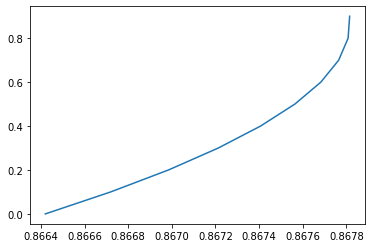

0.9

In [22]:
from model_v2 import model_blending as blend
from sklearn.metrics import roc_auc_score
best_w, best_roc = blend(p_xgb_train, p_cb_train, Y)
best_w

# Model Blending

In [24]:
result = best_w * p_xgb + (1-best_w) *p_cb
filename = "model_blending_cb_xgb_"+split_type+"_best_w-" + datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
save_result(result, filename)